In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import grad
import matplotlib.pyplot as plt
import os
import wave
import struct

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
class Generator(nn.Module):
    def __init__(self, d):
        super(Generator, self).__init__()
        self.d = d
        self.linear1 = nn.Linear(100, 256*d)
        self.tconv1 = nn.ConvTranspose1d(16*d, 8*d, 25, stride = 4, padding = 3)
        self.tconv2 = nn.ConvTranspose1d(8*d, 4*d, 25, stride = 4, padding = 3)
        self.tconv3 = nn.ConvTranspose1d(4*d, 2*d, 25, stride = 4, padding = 0)
        self.tconv4 = nn.ConvTranspose1d(2*d, d, 25, stride = 4, padding = 0)
        self.tconv5 = nn.ConvTranspose1d(d, 1, 25, stride = 3, padding = 0, output_padding = 1)
    
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out.reshape(-1, 16*self.d, 16))
        out = F.relu(self.tconv1(out))
        out = F.relu(self.tconv2(out))
        out = F.relu(self.tconv3(out))
        out = F.relu(self.tconv4(out))
        out = F.relu(self.tconv5(out))
        out = torch.tanh(out)
        return out

In [66]:
# G = nn.ConvTranspose1d(1, 2, 25, stride = 4, dilation = 1, padding = 4)
G = Generator(16)
x = torch.rand(8, 100, dtype = torch.float32)
G_x = G(x)
print(G_x.shape)

torch.Size([8, 1, 16226])


In [130]:
class Discriminator(nn.Module):
    def __init__(self, d):
        super(Discriminator, self).__init__()
        self.d = d
        self.conv1 = nn.Conv1d(1, d, 25, stride = 3, padding = 4)
        self.conv2 = nn.Conv1d(d, 2*d, 25, stride = 4, padding = 4)
        self.conv3 = nn.Conv1d(2*d, 4*d, 25, stride = 4, padding = 4)
        self.conv4 = nn.Conv1d(4*d, 8*d, 25, stride = 4, padding = 4)
        self.conv5 = nn.Conv1d(8*d, 16*d, 25, stride = 4, padding = 4)
        self.linear = nn.Linear(256*d, 1)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = out.reshape(-1, 256*self.d)
        out = self.linear(out)
        return out 

In [131]:
256*16

4096

In [142]:
D = Discriminator(16)
# D = nn.Conv1d(1, 2, 25, stride = 4)
x = torch.rand(8, 1, 16226, dtype = torch.float32)
D_x = D(x)
print(D_x.shape)

torch.Size([8, 1])


In [68]:
data_one = './data/speech_commands_v0.01/one/'
files = os.listdir(data_one)

In [69]:
with wave.open(os.path.join(data_one, files[0])) as f:
    params = f.getparams()

In [70]:
params

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype='NONE', compname='not compressed')

In [71]:
data = []
with wave.open(os.path.join(data_one, files[0])) as f:
    data = f.readframes(params.nframes)

In [72]:
len(data)

32000

In [73]:
float_data = []
for i in range(params.nframes):
    x = struct.unpack('h', data[i:i+2])
    float_data.append(x[0])
float_data = np.array(float_data, dtype = np.float32)

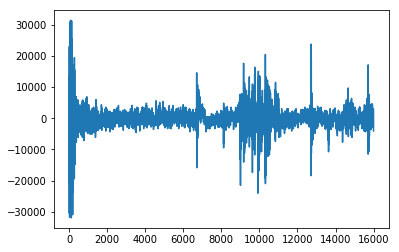

In [74]:
plt.plot(float_data)

In [75]:
float_data = np.pad(float_data, 113, 'constant', constant_values=((0, 0)))

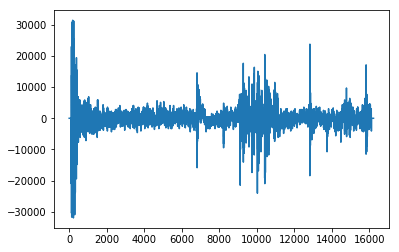

In [76]:
plt.plot(float_data)

In [77]:
float_data.shape

(16226,)

In [78]:
len(files)

2370

In [83]:
base_dir = './data/speech_commands_v0.01/'
# names = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
names = ['one']
files = []
for folder in os.listdir(base_dir):
    if folder in names:
        folder_files = os.listdir(os.path.join(base_dir, folder))
        base = os.path.join(base_dir, folder)
        files.extend([os.path.join(base, f) for f in folder_files])

In [84]:
len(files)

2370

In [85]:
files[0]

'./data/speech_commands_v0.01/one\\00176480_nohash_0.wav'

In [87]:
n_pad = 113
sample_len = 16226
train_data = []
for i, file in enumerate(files):
    with wave.open(file) as f:
        data = f.readframes(params.nframes)
    if len(data) != 32000:
        continue
    data_float = np.zeros((sample_len, ), dtype = np.float32)
    for j in range(0, len(data), 2):
        x_int = struct.unpack('h', data[j:j+2])
        data_float[n_pad + j//2] = float(x_int[0])
    train_data.append(data_float)
train_data = np.array(train_data, dtype = np.float32)

In [88]:
train_data.shape

(2103, 16226)

In [158]:
def get_batch(train_data, batch_size):
    idx = np.random.randint(0, len(train_data), size=batch_size)
    batch = train_data[idx]
    return np.expand_dims(batch, axis = 1)

In [159]:
x = get_batch(train_data, 32)
x.shape

(32, 1, 16226)

In [173]:
batch_size = 32
n = 5
n_disc = 5
r = 10
d = 16
G = Generator(d)
G.to(device)
D = Discriminator(d)
D.to(device)
G_optim = optim.Adam(G.parameters(), 0.0001, betas = (0, 0.9))
D_optim = optim.Adam(D.parameters(), 0.0001, betas = (0, 0.9))
G_losses = []
D_losses = []

In [174]:
real = torch.tensor(get_batch(train_data, 32))
fake = torch.rand(batch_size, 1, 16226)
eps = torch.rand(batch_size, 1, 1)
real_eps = eps*real
print(real_eps.shape)

torch.Size([32, 1, 16226])


In [175]:
for i in range(n):
    for j in range(n_disc):
        real = get_batch(train_data, batch_size)
        real = torch.tensor(real).to(device)
        z = 2*torch.rand(batch_size, 100) - 1
        z = z.to(device)
        fake = G(z)
#         print(fake.shape)
        eps = torch.rand(batch_size, 1, 1).to(device)
        real_fake = eps*real + (1 - eps)*fake
#         print(real_fake.shape)
        D_real = D(real)
        D_fake = D(fake)
        D_real_fake = D(real_fake)
        penalty = r*((torch.norm(grad(D_real_fake,
                                      real_fake,
                                      torch.ones(batch_size, 1).to(device)),
                                 p = 2, dim = 1) - 1)**2)
        D_loss = torch.mean(D_fake - D_real + penalty)
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()
        D_losses.append(D_loss.item())
    
    z = 2*torch.rand(batch_size, 1, 16226) - 1
    z = z.to(device)
    fake = G(z)
    G_loss = torch.mean(-D(fake))
    G_optim.zero_grad()
    G_loss.backward()
    G_optim.step()
    G_losses.append(G_loss.item())
    
    print('G_loss = {:.3}, D_loss = {:.3}'.format(G_losses[-1], D_losses[-1]))

AttributeError: 'tuple' object has no attribute 'dim'

In [28]:
class Module(nn.Module):
    def __init__(self, d):
        super(Module, self).__init__()
        self.linear = nn.Linear(d, 1)
    
    def forward(self, x):
        return torch.tanh(self.linear(x))

In [81]:
batch_size = 16
d = 32
module = Module(d)
x = torch.rand(batch_size, d)
x.requires_grad = True
out = module(x)
grad = torch.autograd.grad(out, x, torch.ones(batch_size, 1))

In [84]:
len(grad)

1

In [79]:
grad[0][0][:15]

tensor([-0.0361,  0.0612,  0.0559, -0.0090,  0.0397,  0.0028, -0.0458,  0.0589,
         0.0451,  0.0026, -0.0222,  0.0476, -0.0385,  0.0097,  0.0746])